In [1]:

from Utils import *

/Users/zhihiuchen/Documents/Roadviewer/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
os.chdir('/Volumes/Extreme SSD/RoadviewerData')

ransac = RANSACRegressor(min_samples=100, max_trials=100, residual_threshold=1, loss='squared_error')
# read route centerline data, this is in NV
route = gpd.read_file('./StatewideRoutes/StatewideRoutes.shp')
# convert crs to the same as the raster
# out_path = r'./'
# if not os.path.exists(out_path):
#     os.mkdir(out_path)
# set the working directory to /Volumes/Extreme SSD/RoadviewerData
grid_size = 0.05
cos_thresh = 0.5  # Cosine similarity threshold in the spline tracking
conv_thred = 70


In [14]:
las_path = r'./LasFolder/134316WA_+_012.las'
out_path = r'./TiffFolder/134316WA_+_012.tif'
# out_path = f'./{name}.tif'
raster_cropped, boundary, crs= get_raster(las_path,ransac,grid_size)
min_x, max_x, min_y, max_y = boundary
# generate the mask of the raster boundary according to the max and min x and y values of the raster
mask = [min_x,min_y,max_x,max_y]
# clip the route data according to the mask
route = route.to_crs(crs)
route_clip = gpd.clip(route, mask)
# extract the longest route
route_clip = route_clip[route_clip.geometry.length == route_clip.geometry.length.max()]
# if len(route_clip) == 0:
#     continue 
# Define the fixed distance step at which to sample the route
step_meter = 5 # meters
intensity_image = raster_cropped[0]
sub_section_centerline_points,perp_masks,interpolated_points_meter,edges,route_clip_image = get_sections(route_clip, intensity_image,step_meter,grid_size,min_x,min_y,max_x,max_y)
total_conv_map, total_route_image, sub_high_conv_images, sub_route_clip_images, sub_edge_bboxs, sub_route_bboxs, valid_centerline_points = get_conv_map(edges,perp_masks,route_clip_image,sub_section_centerline_points,conv_thred)
total_spline_coords,total_dis_splines2intersects_list,section_heading_vecs,auxilary_proj_dis_list,TotalCoords_meter_list,mid_pt_list =  get_spline_coords(sub_high_conv_images,sub_edge_bboxs,valid_centerline_points,grid_size,min_x,min_y,max_x,max_y)
raster_cropped_, spline_polys = get_spline_poly(raster_cropped,section_heading_vecs,total_spline_coords,total_dis_splines2intersects_list,min_x,min_y,cos_thresh = 0.5,grid_size = 0.05)

# Define the transformation, left-bottom corner is min_x, max_y, and right-top corner is max_x, min_y
transform = from_origin(min_x, max_y, grid_size, grid_size)
# save the raster to a tiff file. The first layer is intensity, the second layer is elevation, and the third layer is density, respectively. raster[y,x] refers to the value at x,y in the plane, and the origin of raster is at the left-upper corner
raster_cropped_flipped = np.flip(raster_cropped_, axis=1)
with rasterio.open(out_path, 'w', driver='GTiff', height=raster_cropped_flipped.shape[1], width=raster_cropped_flipped.shape[2], count=4, dtype=raster_cropped_flipped.dtype, crs=crs, transform=transform) as dst:
    dst.write(raster_cropped_flipped)

62it [00:07,  7.86it/s]
100%|██████████| 44/44 [00:00<00:00, 123.17it/s]


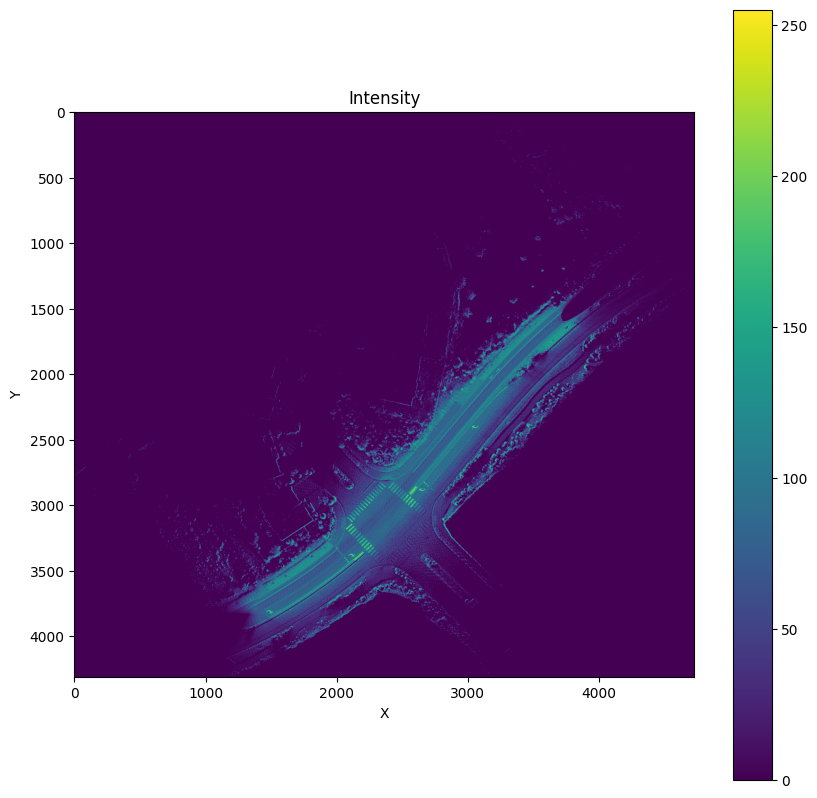

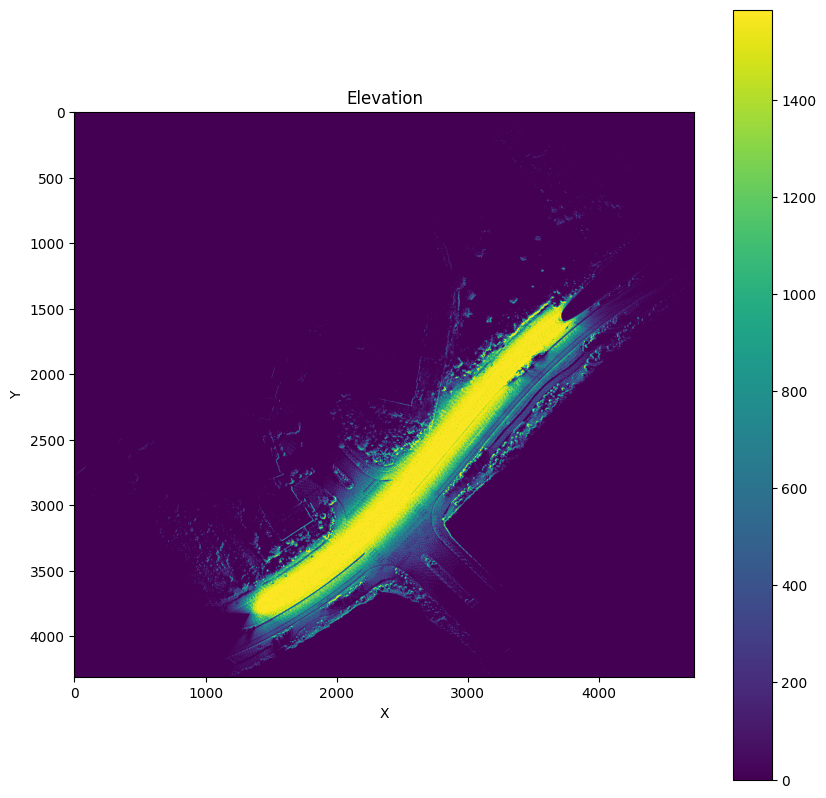

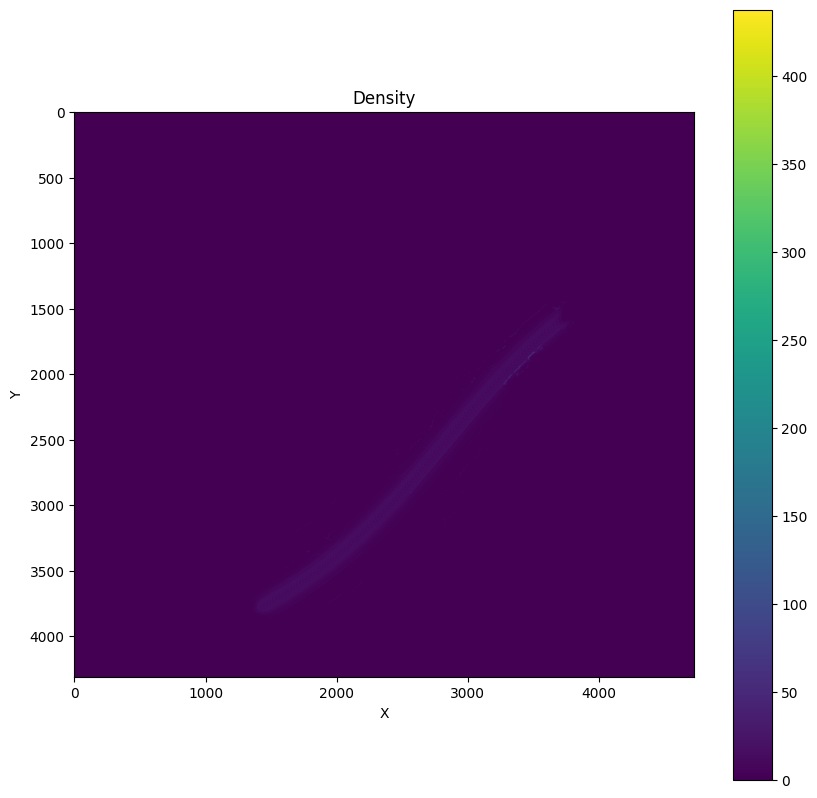

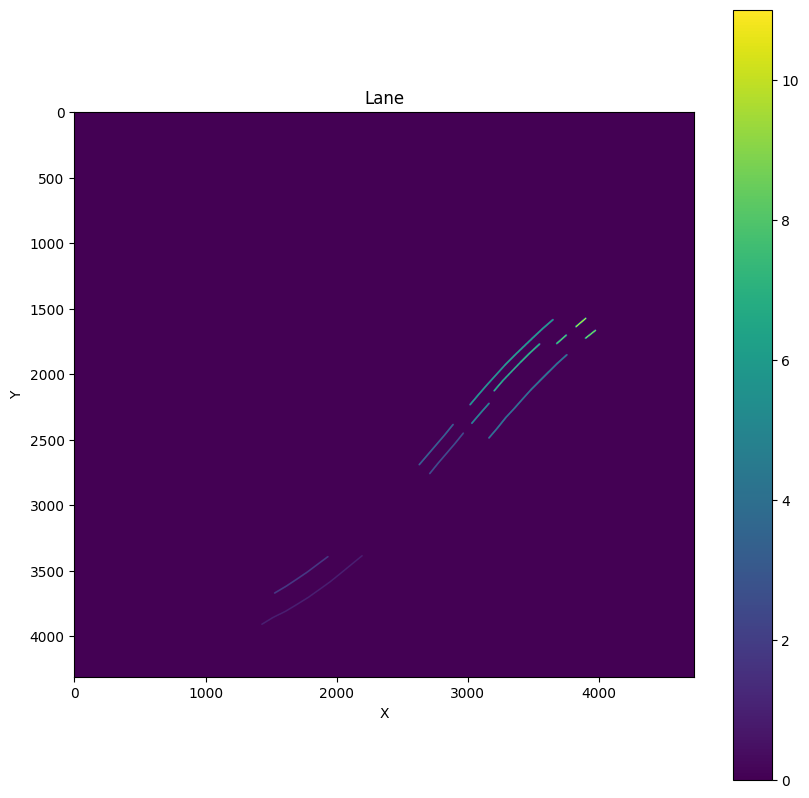

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(raster_cropped_[0])
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Intensity")
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(raster_cropped_[1])
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Elevation")
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(raster_cropped_[2])
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Density")
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(raster_cropped_[3])
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Lane")
plt.show()

In [ ]:
las_path = r'./LasFolder/134316WA_+_012.las'
out_path = r'./TiffFolder/134316WA_+_012.tif'
# out_path = f'./{name}.tif'
def generate_comprehensive_raster(las_path,out_path,ransac,grid_size,conv_thred,route):
    raster_cropped, boundary, crs= get_raster(las_path,ransac,grid_size)
    min_x, max_x, min_y, max_y = boundary
    # generate the mask of the raster boundary according to the max and min x and y values of the raster
    mask = [min_x,min_y,max_x,max_y]
    # clip the route data according to the mask
    route = route.to_crs(crs)
    route_clip = gpd.clip(route, mask)
    # extract the longest route
    route_clip = route_clip[route_clip.geometry.length == route_clip.geometry.length.max()]
    # if len(route_clip) == 0:
    #     continue 
    # Define the fixed distance step at which to sample the route
    step_meter = 5 # meters
    intensity_image = raster_cropped[0]
    sub_section_centerline_points,perp_masks,interpolated_points_meter,edges,route_clip_image = get_sections(route_clip, intensity_image,step_meter,grid_size,min_x,min_y,max_x,max_y)
    total_conv_map, total_route_image, sub_high_conv_images, sub_route_clip_images, sub_edge_bboxs, sub_route_bboxs, valid_centerline_points = get_conv_map(edges,perp_masks,route_clip_image,sub_section_centerline_points,conv_thred)
    total_spline_coords,total_dis_splines2intersects_list,section_heading_vecs,auxilary_proj_dis_list,TotalCoords_meter_list,mid_pt_list =  get_spline_coords(sub_high_conv_images,sub_edge_bboxs,valid_centerline_points,grid_size,min_x,min_y,max_x,max_y)
    raster_cropped_, spline_polys = get_spline_poly(raster_cropped,section_heading_vecs,total_spline_coords,total_dis_splines2intersects_list,min_x,min_y,cos_thresh = 0.5,grid_size = 0.05)

    # Define the transformation, left-bottom corner is min_x, max_y, and right-top corner is max_x, min_y
    transform = from_origin(min_x, max_y, grid_size, grid_size)
    # save the raster to a tiff file. The first layer is intensity, the second layer is elevation, and the third layer is density, respectively. raster[y,x] refers to the value at x,y in the plane, and the origin of raster is at the left-upper corner
    raster_cropped_flipped = np.flip(raster_cropped_, axis=1)
    with rasterio.open(out_path, 'w', driver='GTiff', height=raster_cropped_flipped.shape[1], width=raster_cropped_flipped.shape[2], count=4, dtype=raster_cropped_flipped.dtype, crs=crs, transform=transform) as dst:
        dst.write(raster_cropped_flipped)

In [ ]:
# multi-processing to generate the comprehensive raster
las_folder = r'./LasFolder'
out_folder = r'./TiffFolder'
las_files = os.listdir(las_folder)
n_cores = 8
pool = Pool(n_cores)
pool.starmap(generate_comprehensive_raster, [(os.path.join(las_folder,las_file),os.path.join(out_folder,las_file.replace('.las','.tif')),ransac,grid_size,conv_thred,route) for las_file in las_files])
pool.close()